In [ ]:
import os
import json
import pandas as pd
from datasets import load_dataset
from openai import OpenAI
from dotenv import load_dotenv
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import hashlib # For Caching


## Label Distribution by Policies

In [ ]:


# 1. 환경 설정 및 키 로드
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))


In [27]:

# 2. 캐시 시스템 구현 (연구 재현성 확보)
CACHE_FILE = "../data/llm_cache.json"
try:
    with open(CACHE_FILE, 'r') as f:
        cache = json.load(f)
except (FileNotFoundError, json.JSONDecodeError):
    cache = {}

def get_cache_key(text, prompt):
    """Generates a unique hash key for caching."""
    return hashlib.sha256((text + prompt).encode('utf-8')).hexdigest()

def save_cache():
    """Saves the cache to the file."""
    with open(CACHE_FILE, 'w') as f:
        json.dump(cache, f)



In [19]:
# 3. LLM 라벨링 함수 (3단계 분류 및 정규화)
def get_llm_judgment_and_normalize(text, prompt_version):
    """Calls LLM and ensures output is normalized to 'Low', 'Medium', or 'High'."""
    
    if prompt_version == "policy_A":
        # Policy A: Permissive (Only extreme content is High)
        system_prompt = "You are a content moderator enforcing a permissive policy. Classify the user comment's toxicity level as 'Low', 'Medium', or 'High'. Only 'High' should be used for explicit hate speech or threats. Output only the label."
    elif prompt_version == "policy_B":
        # Policy B: Strict (Flag mild insults and sarcasm as Medium/High)
        system_prompt = "You are a content moderator enforcing a strict policy. Classify the user comment's toxicity level as 'Low', 'Medium', or 'High'. Use 'Medium' for all insults, sarcasm, or informal criticism. Use 'High' for all explicit hate speech or threats. Output only the label."

    # Caching check
    cache_key = get_cache_key(text, system_prompt)
    if cache_key in cache:
        return cache[cache_key]

    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": f"Comment: {text}"}
            ],
            temperature=0.1 
        )
        raw_output = response.choices[0].message.content.strip().upper()
        
        # Output Normalization (Ensures only 'LOW', 'MEDIUM', 'HIGH' are returned)
        if 'LOW' in raw_output:
            normalized_label = 'Low'
        elif 'MEDIUM' in raw_output:
            normalized_label = 'Medium'
        elif 'HIGH' in raw_output:
            normalized_label = 'High'
        else:
            normalized_label = 'Error'
            
        # Update cache
        cache[cache_key] = normalized_label
        return normalized_label
        
    except Exception as e:
        print(f"API Error for text: {text[:50]}... Error: {e}")
        return "Error"



In [21]:
# 4. 데이터 로드 및 감사(Audit) 실행
print("Loading Civil Comments Dataset...")
# 100개로 늘려서 분석의 깊이를 더합니다.
dataset = load_dataset("civil_comments", split="train[:100]") 
df_raw = pd.DataFrame(dataset)

# 필요한 컬럼만 선택하고 정규화
df_raw = df_raw.rename(columns={'toxicity': 'ground_truth_toxicity_score'})
df_raw = df_raw[['text', 'ground_truth_toxicity_score', 'identity_attack', 'threat']] # 주제별 라벨 포함
df_raw['id'] = range(len(df_raw)) # 고유 ID를 직접 만듭니다.



Loading Civil Comments Dataset...


In [28]:

# 5. Long Format 결과 리스트 초기화
results_long_format = []

print("Starting Audit with LLM...")
for index, row in tqdm(df_raw.iterrows(), total=len(df_raw)):
    text = row['text']
    
    # Policy A
    label_A = get_llm_judgment_and_normalize(text, "policy_A")
    results_long_format.append({
        'id': row['id'], 'text': text, 'Policy': 'Permissive (A)', 
        'LLM_Toxicity_Label': label_A, 'Ground_Score': row['ground_truth_toxicity_score'],
        'Category': 'identity_attack' if row['identity_attack'] > 0.5 else 'general'
    })

    # Policy B
    label_B = get_llm_judgment_and_normalize(text, "policy_B")
    results_long_format.append({
        'id': row['id'], 'text': text, 'Policy': 'Strict (B)', 
        'LLM_Toxicity_Label': label_B, 'Ground_Score': row['ground_truth_toxicity_score'],
        'Category': 'identity_attack' if row['identity_attack'] > 0.5 else 'general'
    })

# 6. 저장 및 캐시 저장
df_final = pd.DataFrame(results_long_format)
df_final.to_csv("../data/audit_results_long.csv", index=False)
save_cache()

print("\n--- Audit Complete: Data Ready for LLOOM-style Analysis ---")
print(f"Final data saved to data/audit_results_long.csv (Total {len(df_final)} rows)")
print("\nDistribution Summary (Policy B vs A):")
print(df_final.groupby('Policy')['LLM_Toxicity_Label'].value_counts(normalize=True))

Starting Audit with LLM...


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


--- Audit Complete: Data Ready for LLOOM-style Analysis ---
Final data saved to data/audit_results_long.csv (Total 200 rows)

Distribution Summary (Policy B vs A):
Policy          LLM_Toxicity_Label
Permissive (A)  Low                   0.99
                High                  0.01
Strict (B)      Low                   0.74
                Medium                0.18
                High                  0.08
Name: proportion, dtype: float64


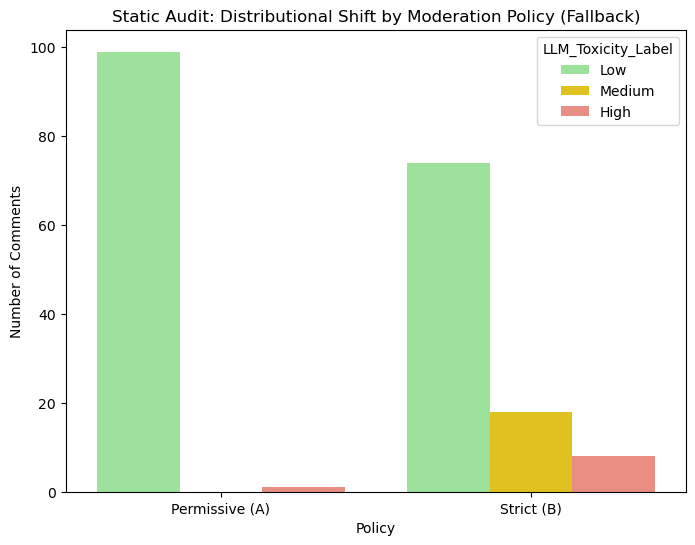

In [35]:
def run_static_visualization(df):
    """FallBack: LLOOM 로드 실패 시 Matplotlib으로 정적 그래프를 그립니다."""
    import seaborn as sns
    # (이전에 만든 Matplotlib 코드 그대로)
    df_long = pd.melt(df, id_vars=['text'], value_vars=['LLM_Toxicity_Label'], 
                      var_name='Analysis_Type', value_name='Label')
    
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x='Policy', hue='LLM_Toxicity_Label', 
                  order=['Permissive (A)', 'Strict (B)'], 
                  hue_order=['Low', 'Medium', 'High'], 
                  palette={'Low': 'lightgreen', 'Medium': 'gold', 'High': 'salmon'})
    
    plt.title("Static Audit: Distributional Shift by Moderation Policy (Fallback)")
    plt.ylabel("Number of Comments")
    plt.savefig("../data/static_distribution_plot.png")
    plt.show()

run_static_visualization(df_final)


## Distribution Change Analysis

In [ ]:

# Convert long-format audit results to wide format for LLooM

IN_PATH = "../data/audit_results_long.csv"
OUT_PATH = "../data/lloom_input_wide.csv"

df = pd.read_csv(IN_PATH)

# Rename
df = df.rename(columns={
    "Policy": "policy",
    "LLM_Toxicity_Label": "label",
    "Ground_Score": "toxicity_score",
    "Category": "category",
})

# Pick columns
df = df[["id", "text", "policy", "label", "toxicity_score", "category"]].copy()

# Label
df["label"] = df["label"].astype(str).str.strip().str.title()

# Wide pivot
wide = df.pivot_table(
    index=["id", "text", "toxicity_score", "category"],
    columns="policy",
    values="label",
    aggfunc="first"
).reset_index()

# 컬럼 이름 확인
print("Policy columns found:", [c for c in wide.columns if c not in ["id", "text", "toxicity_score", "category"]])
wide.head()


Policy columns found: ['Permissive (A)', 'Strict (B)']


policy,id,text,toxicity_score,category,Permissive (A),Strict (B)
0,0,"This is so cool. It's like, 'would you want yo...",0.000000,general,Low,Low
1,1,Thank you!! This would make my life a lot less...,0.000000,general,Low,Low
2,2,This is such an urgent design problem; kudos t...,0.000000,general,Low,Low
3,3,Is this something I'll be able to install on m...,0.000000,general,Low,Low
4,4,haha you guys are a bunch of losers.,0.893617,general,Low,Medium


In [ ]:
#셀 2: flagged_by 생성하기 (A only, B only, both, none)

policy_cols = [c for c in wide.columns if c not in ["id", "text", "toxicity_score", "category"]]
if len(policy_cols) < 2:
    raise ValueError("Need two policy columns. Check your policy names in the source CSV.")

# 여기서는 이름에 A와 B가 들어간 컬럼을 우선적으로 잡는다
a_col = None
b_col = None
for c in policy_cols:
    if "Permissive" in c or "(A)" in c:
        a_col = c
    if "Strict" in c or "(B)" in c:
        b_col = c

# 못 찾으면 그냥 첫 두 개 사용
if a_col is None or b_col is None:
    a_col, b_col = policy_cols[0], policy_cols[1]

print("Using A column:", a_col)
print("Using B column:", b_col)

def is_flagged(lbl: str) -> bool:
    return str(lbl).strip().title() in ["Medium", "High"]

wide["flag_A"] = wide[a_col].apply(is_flagged)
wide["flag_B"] = wide[b_col].apply(is_flagged)

def flagged_by(row):
    a = bool(row["flag_A"])
    b = bool(row["flag_B"])
    if a and b:
        return "both"
    if a and not b:
        return "A_only"
    if b and not a:
        return "B_only"
    return "none"

wide["flagged_by"] = wide.apply(flagged_by, axis=1)

# 라벨 차이도 같이 만들어두면 편함
wide["label_changed"] = (wide[a_col].astype(str) != wide[b_col].astype(str))

wide[["id", "category", a_col, b_col, "flagged_by", "label_changed"]].head(10)


Using A column: Permissive (A)
Using B column: Strict (B)


policy,id,category,Permissive (A),Strict (B),flagged_by,label_changed
0,0,general,Low,Low,none,False
1,1,general,Low,Low,none,False
2,2,general,Low,Low,none,False
3,3,general,Low,Low,none,False
4,4,general,Low,Medium,B_only,True
5,5,general,Low,Medium,B_only,True
6,6,general,Low,Low,none,False
7,7,general,Low,High,B_only,True
8,8,general,Low,Low,none,False
9,9,general,Low,Low,none,False


In [44]:
lloom_df = wide.copy()

# none 제거하면 시각화가 훨씬 선명해짐
lloom_df = lloom_df[lloom_df["flagged_by"] != "none"].copy()

# 텍스트 길이 제한
lloom_df["text"] = lloom_df["text"].astype(str).str.slice(0, 800)

# 저장
lloom_df.to_csv(OUT_PATH, index=False)
print("Saved:", OUT_PATH)
print("flagged_by distribution:")
print(lloom_df["flagged_by"].value_counts())


Saved: ../data/lloom_input_wide.csv
flagged_by distribution:
flagged_by
B_only    25
both       1
Name: count, dtype: int64


In [46]:
import text_lloom.workbench as wb


# 키는 환경변수로 이미 들어있으면 이 줄은 생략 가능
# os.environ["OPENAI_API_KEY"] = "YOUR_KEY_HERE"

df = pd.read_csv("../data/lloom_input_wide.csv")

l = wb.lloom(
    df=df,
    text_col="text",
    id_col="id",
)

score_df = await l.gen_auto(seed=None, max_concepts=8)

# 정책 선택이 만든 집합 차이를 비교하는 핵심 화면
l.vis(slice_col="flagged_by")

# 필요하면 category도 같이
l.vis(slice_col="category")

l.summary()


N sentences: Median=3, Std=2.67
Auto-suggested parameters: {'filter_n_quotes': 3, 'summ_n_bullets': 2, 'synth_n_concepts': 6}


Estimated cost: $0.05
**Please note that this is only an approximate cost estimate**


Action required


Distill-filter
✅ Done    


,id,text
0,4,haha\nyou guys\na bunch of losers
1,5,ur a sh*tty comment
2,7,FFFFUUUUUUUUUUUUUUU
3,13,It's ridiculous that these guys are being call...
4,14,This story gets more ridiculous by the hour!\n...
5,15,I don't want to grant them the legitimacy of p...
6,19,"Angry trolls, misogynists and Racists\nWe can ..."
7,30,devoid of content\nyou work for WW\nFred Armis...
8,31,Yet call out all Muslims for the acts of a few...
9,34,This bitch is nuts.\nWho would read a book by ...




Distill-summarize
✅ Done    


,id,text
0,4,Lighthearted teasing among friends
1,4,Playful banter about group dynamics
2,5,Negative comment about someone
3,5,Use of profanity in expression
4,7,Expression of frustration or anger
5,7,Intense emotional reaction conveyed
6,13,Armed individuals threaten violence
7,13,Labeling them as protesters is absurd
8,14,Story becomes increasingly absurd over time
9,14,People mock situation with humorous gifts




Cluster
⠹ Loading 

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


✅ Done    


,id,text,cluster_id
25,49,require frequent repainting and maintenance,-1
28,56,Tax residency based on ticket purchase,-1
27,52,Tax policies impact housing affordability,-1
26,52,Affordable housing affected by taxes,-1
24,49,spend money on fashionable projects,-1
23,44,Frustration over high taxes and expenses,-1
34,73,Framed boxes increase code and bandwidth,-1
35,73,Users dislike excessive 'more replies' clicks,-1
20,40,Voting system is time-consuming,-1
37,75,Defending teenagers' Christmas traditions,-1




Synthesize
✅ Done    


Input examples: ['require frequent repainting and maintenance', 'Tax residency based on ticket purchase', 'Tax policies impact housing affordability', 'Affordable housing affected by taxes', 'spend money on fashionable projects', 'Frustration over high taxes and expenses', 'Framed boxes increase code and bandwidth', "Users dislike excessive 'more replies' clicks", 'Voting system is time-consuming', "Defending teenagers' Christmas traditions", "Negative view of a woman's writing", 'Summarizing heavy vibes feelings', 'A call to return to California', 'Urgent delivery needed', "Fred Armisen's role in GTA IV", 'Misrepresentation of furrier interests', 'Diversity allows unrestricted expression', 'Taking from all to benefit a few', 'Protestors lack legitimacy and greed', 'Diverse hobbies beyond fur culture', 'Civility in political agreement matters', 'Intense emotional reaction conveyed', 'Questioning experience on Hawthorne', 'Suggesting Float On as an activity', '

In [58]:
l.save(folder="../data/",file_name="run1")

Saved session to ../data//run1.pkl


In [ ]:
# 정책 선택이 만든 집합 차이를 비교하는 핵심 화면
l.vis(slice_col="flagged_by")


In [4]:

# 필요하면 category도 같이
l.vis(slice_col="category")

In [6]:
export_df = l.export_df()
export_df.to_csv("../data/lLoom_results.csv", index=False)
